In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname
!pwd
import sys
print(sys.executable)

isola-2080ti-3.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
os.environ['JAX_DEBUG_NANS'] = 'True'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'False'

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax import linen as nn
import jax.numpy as jnp
from flax.training.train_state import TrainState
import jax
from jax.random import split
from mdps.random_net import RandomMLP, create_random_net

from functools import partial

from agents.regular_transformer import BCTransformer
from tqdm.auto import tqdm

from typing import Callable


In [3]:
with open("../data/exp_icl/datasets/real/classic/name=MountainCar-v0/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
n_acts = dataset['logits'].shape[-1]
d_obs = dataset['obs'].shape[-1]
print(n_acts, d_obs)

3 2


In [5]:
rng = jax.random.PRNGKey(0)

net = RandomMLP(n_layers=4, d_hidden=64, d_out=n_acts, activation=jax.nn.relu)

rng, _rng = split(rng)
x = jax.random.normal(_rng, (32, d_obs))
rng, _rng = split(rng)
net_params = create_random_net(net, _rng, x)

rng, _rng = split(rng)
obs = jax.random.normal(_rng, (4096, 128, d_obs))
logits = 5 * jax.vmap(jax.vmap(partial(net.apply, net_params)))(obs)

rng, _rng = split(rng)
act = jax.random.categorical(_rng, logits)

dataset_syn = dict(obs=obs, logits=logits, act=act)

In [7]:
dataset = jax.tree_map(lambda x: jnp.array(x), dataset)
dataset_syn = jax.tree_map(lambda x: jnp.array(x), dataset_syn)
print(jax.tree_map(lambda x: x.shape, dataset))
print(jax.tree_map(lambda x: x.shape, dataset_syn))

{'act': (4096, 128), 'logits': (4096, 128, 3), 'obs': (4096, 128, 2)}
{'act': (4096, 128), 'logits': (4096, 128, 3), 'obs': (4096, 128, 2)}


In [63]:
agent = BCTransformer(n_acts=3, n_layers=4, n_heads=8, d_embd=256, n_steps=128)

In [64]:
def train_agent(params, dataset, rng, n_steps):
    tx = optax.chain(optax.clip_by_global_norm(1.), optax.adam(3e-4, eps=1e-8))
    train_state = TrainState.create(apply_fn=agent.apply, params=params, tx=tx)

    def loss_fn_bc(agent_params, batch):
        logits = jax.vmap(agent.apply, in_axes=(None, 0, 0))(agent_params, batch['obs'], batch['act'])
        # ce_label = optax.softmax_cross_entropy_with_integer_labels(logits, batch['act'])
        ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits), jax.nn.softmax(batch['logits'])).mean(axis=0)
        loss = ce.mean()
        metrics = dict(loss=loss, ce=ce)
        return loss, metrics
    
    def iter_step(train_state, batch):
        (_, metrics), grads = jax.value_and_grad(loss_fn_bc, has_aux=True)(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state, metrics

    iter_step = jax.jit(iter_step)
    
    ce = []
    pbar = tqdm(range(n_steps))
    for i_step in pbar:
        rng, _rng = split(rng)
        idx_batch = jax.random.randint(_rng, (256,), 0, 4096)
        batch = jax.tree_map(lambda x: x[idx_batch], dataset)
        
        train_state, metrics = iter_step(train_state, batch)
        ce.append(metrics['ce'])
        pbar.set_postfix({'loss': metrics['loss'].mean()})
    ce = jnp.stack(ce)
    return train_state.params, ce
        

In [11]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
params_init = agent.init(_rng, jnp.zeros((128, 2)), jnp.zeros((128, ), dtype=int))

rng = jax.random.PRNGKey(1)
params_syn, ce_syn = train_agent(params_init, dataset_syn, rng, 100)

rng = jax.random.PRNGKey(1)
_, ce_scratch = train_agent(params_init, dataset, rng, 100)

rng = jax.random.PRNGKey(1)
_, ce_pre = train_agent(params_syn, dataset, rng, 100)


2024-02-21 13:16:08.720860: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error
2024-02-21 13:16:08.720922: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.7; current profiling annotation: XlaModule:#prefix=jit(qr)/jit(main),hlo_module=jit_qr,program_id=198#.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.7; current profiling annotation: XlaModule:#prefix=jit(qr)/jit(main),hlo_module=jit_qr,program_id=198#.

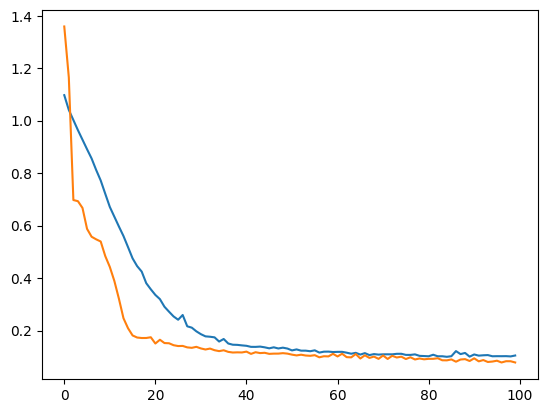

In [20]:
plt.plot(ce_scratch.mean(axis=1))
plt.plot(ce_pre.mean(axis=1))
ce_syn.mean(axis=1)

In [8]:
class MLP(nn.Module):
    n_layers: int
    d_hidden: int
    d_out: int
    activation: Callable

    @nn.compact
    def __call__(self, x, train=False):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.d_hidden, kernel_init=nn.initializers.kaiming_normal())(x)
            x = self.activation(x)
        x = nn.Dense(features=self.d_out, kernel_init=nn.initializers.kaiming_normal())(x)
        return x
agent = MLP(n_layers=4, d_hidden=64, d_out=n_acts, activation=jax.nn.relu)

In [10]:
def train_agent(params, dataset, rng, n_steps, lr=3e-4):
    tx = optax.chain(optax.clip_by_global_norm(1.), optax.adam(lr, eps=1e-8))
    train_state = TrainState.create(apply_fn=agent.apply, params=params, tx=tx)

    def loss_fn_bc(agent_params, batch):
        logits = jax.vmap(jax.vmap(partial(agent.apply, agent_params)))(batch['obs'])
        ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits), jax.nn.softmax(batch['logits'])).mean(axis=0)
        loss = ce.mean()
        metrics = dict(loss=loss, ce=ce)
        return loss, metrics

    def iter_step(train_state, batch):
        (_, metrics), grads = jax.value_and_grad(loss_fn_bc, has_aux=True)(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state, metrics

    iter_step = jax.jit(iter_step)

    ce = []
    pbar = tqdm(range(n_steps))
    for i_step in pbar:
        rng, _rng = split(rng)
        idx_batch = jax.random.randint(_rng, (256,), 0, 4096)
        batch = jax.tree_map(lambda x: x[idx_batch], dataset)

        train_state, metrics = iter_step(train_state, batch)
        ce.append(metrics['ce'])
        pbar.set_postfix({'loss': metrics['loss'].mean()})
    ce = jnp.stack(ce)
    return train_state.params, ce

rng = jax.random.PRNGKey(1)
rng, _rng = split(rng)
params_init = agent.init(_rng, jnp.zeros((d_obs, )))
# params_init = create_random_net(agent, _rng, jax.random.normal(rng, (32, d_obs, )))

rng, _rng = split(rng)
params_syn, ce_syn = train_agent(params_init, dataset_syn, _rng, n_steps=1000, lr=3e-4)

rng, _rng = split(rng)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
def train_agent_lr(params, lr=3e-4):
    rng = jax.random.PRNGKey(1)
    _, ce = train_agent(params, dataset, rng, 500, lr=lr)
    return ce
train_agent_lr = jax.vmap(train_agent_lr, in_axes=(None, 0))

lrs = jnp.array([1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1])
ces_pre = train_agent_lr(params_syn, lrs)
ces_scratch = train_agent_lr(params_init, lrs)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

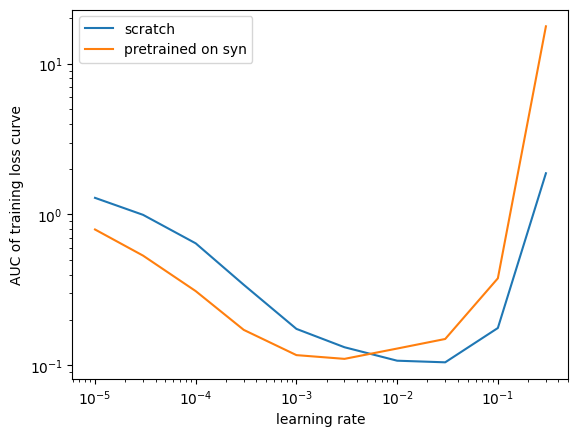

In [12]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

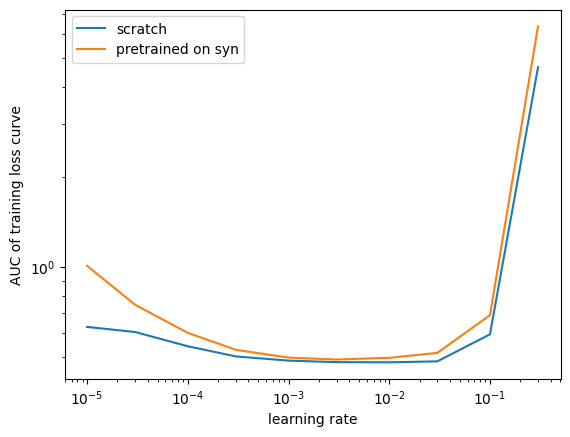

In [57]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

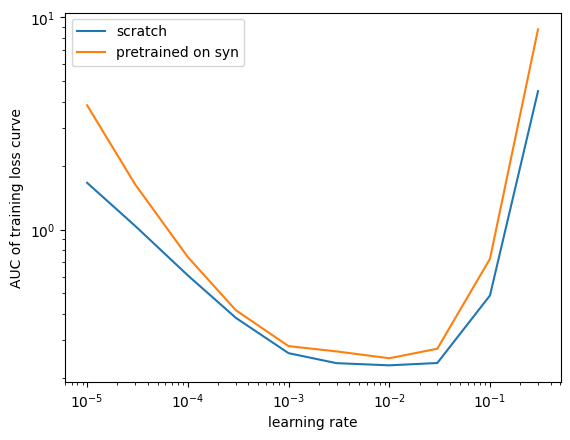

In [50]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

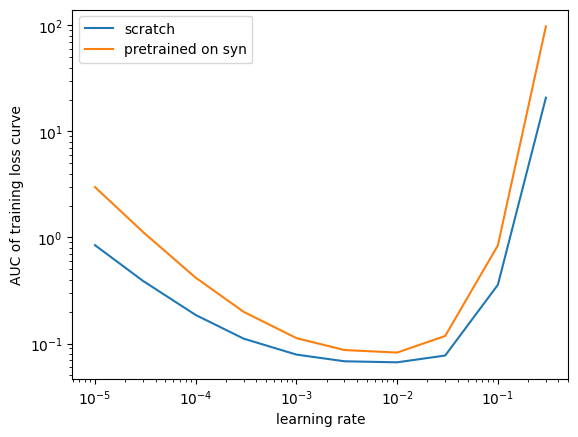

In [38]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

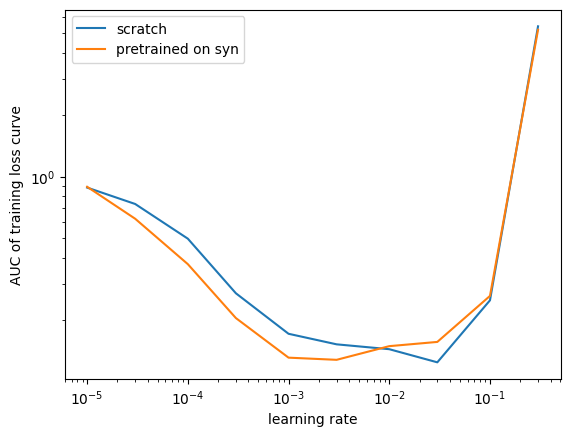

In [31]:
plt.plot(lrs, ces_scratch.mean(axis=(-1, -2)), label='scratch')
plt.plot(lrs, ces_pre.mean(axis=(-1, -2)), label='pretrained on syn')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('AUC of training loss curve')
plt.show()

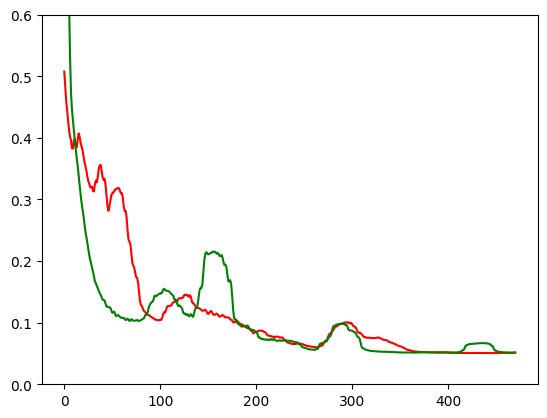

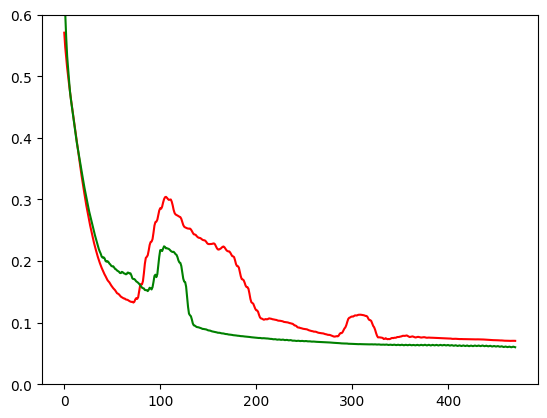

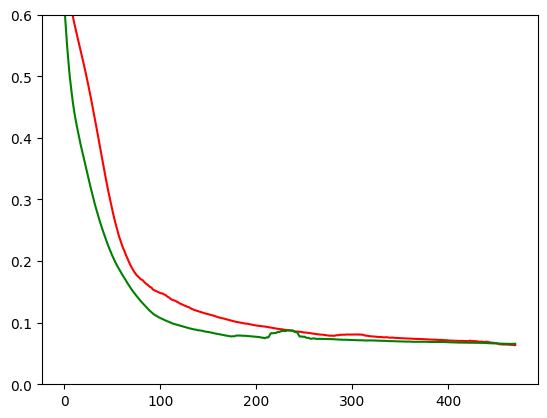

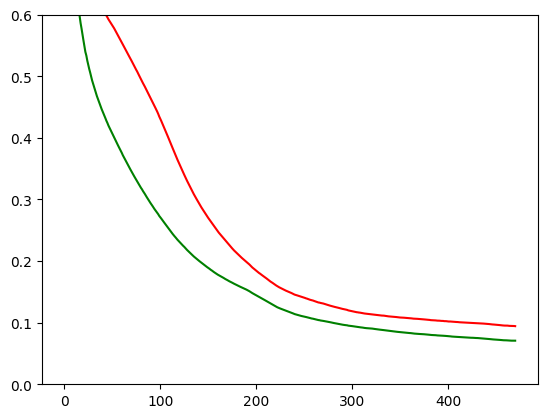

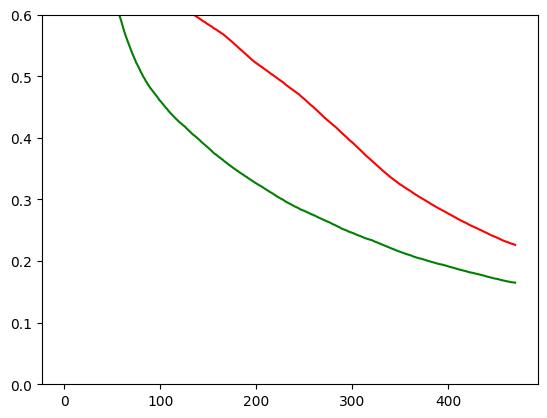

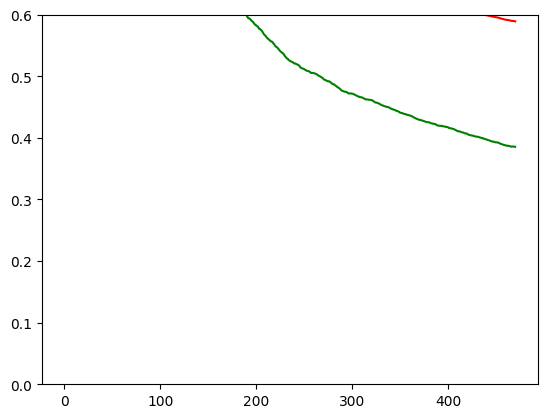

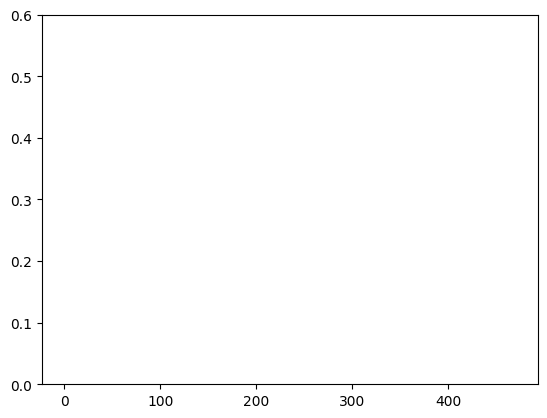

In [28]:
for i in range(7):
    a = ces_scratch.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='r')
    a = ces_pre.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='g')
    plt.ylim(0, 0.6)
    plt.show()

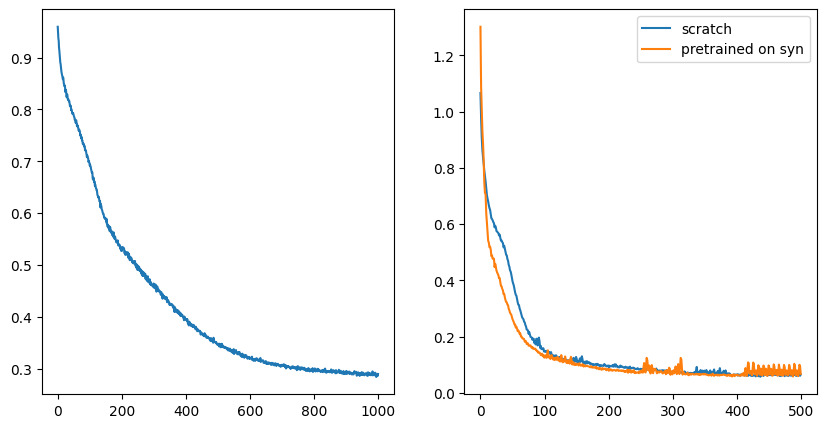

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(ce_syn.mean(axis=1))

plt.subplot(122)
plt.plot(ce_scratch.mean(axis=1), label='scratch')
plt.plot(ce_pre.mean(axis=1), label='pretrained on syn')
plt.legend()
plt.show()

In [31]:
agent = RandomMLP(n_layers=4, d_hidden=64, d_out=n_acts, activation=jax.nn.relu)

def train_agent(params, dataset, rng, n_steps, lr=3e-4):
    tx = optax.chain(optax.clip_by_global_norm(1.), optax.adam(lr, eps=1e-8))
    train_state = TrainState.create(apply_fn=agent.apply, params=params, tx=tx)

    def loss_fn_bc(agent_params, batch):
        logits = jax.vmap(jax.vmap(partial(agent.apply, agent_params)))(batch['obs'])
        ce = optax.softmax_cross_entropy(jax.nn.log_softmax(logits), jax.nn.softmax(batch['logits'])).mean(axis=0)
        loss = ce.mean()
        metrics = dict(loss=loss, ce=ce)
        return loss, metrics

    def iter_step(train_state, batch):
        (_, metrics), grads = jax.value_and_grad(loss_fn_bc, has_aux=True)(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        return train_state, metrics

    iter_step = jax.jit(iter_step)

    ce = []
    pbar = tqdm(range(n_steps))
    for i_step in pbar:
        rng, _rng = split(rng)
        idx_batch = jax.random.randint(_rng, (256,), 0, 4096)
        batch = jax.tree_map(lambda x: x[idx_batch], dataset)

        train_state, metrics = iter_step(train_state, batch)
        ce.append(metrics['ce'])
        pbar.set_postfix({'loss': metrics['loss'].mean()})
    ce = jnp.stack(ce)
    return train_state.params, ce

rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
# params_init = agent.init(_rng, jnp.zeros((d_obs, )))
params_init = create_random_net(agent, _rng, jax.random.normal(rng, (32, d_obs, )))

rng, _rng = split(rng)
params_syn, ce_syn = train_agent(params_init, dataset_syn, _rng, 1000)

rng, _rng = split(rng)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
def train_agent_lr(params, lr=3e-4):
    _, ce = train_agent(params, dataset, _rng, 500, lr=lr)
    return ce
train_agent_lr = jax.vmap(train_agent_lr, in_axes=(None, 0))
lrs = jnp.array([1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5])
ces_pre = train_agent_lr(params_syn, lrs)
ces_scratch = train_agent_lr(params_init, lrs)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

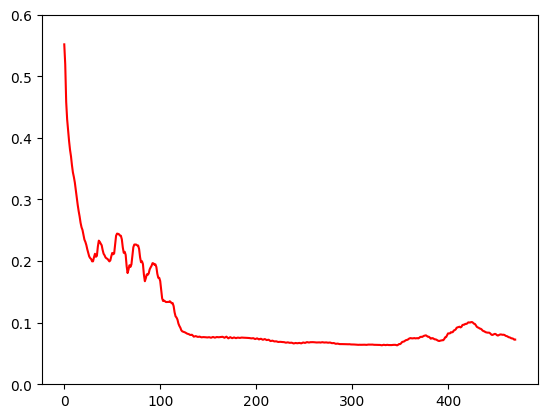

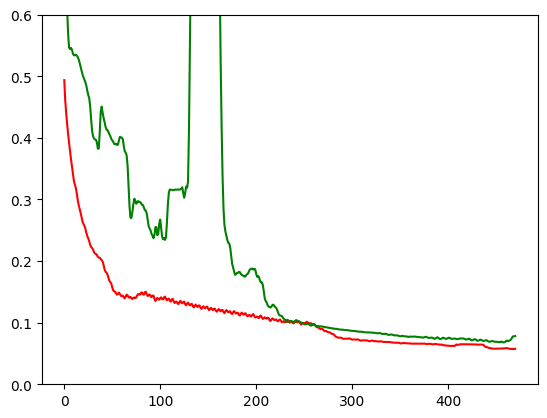

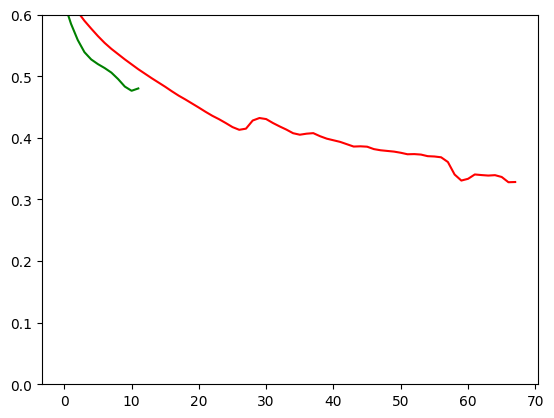

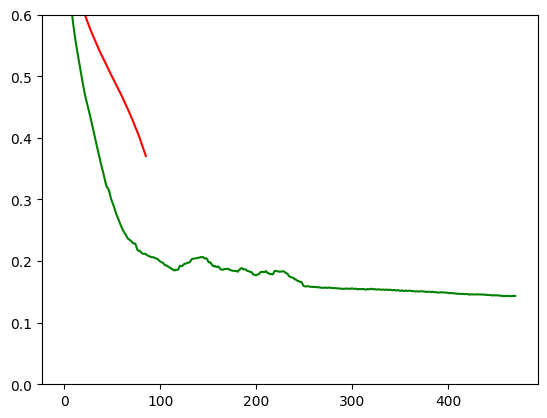

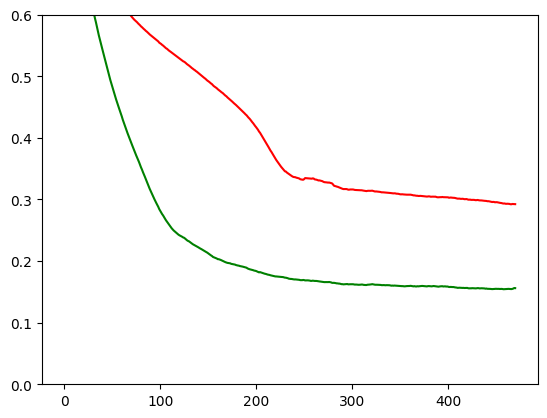

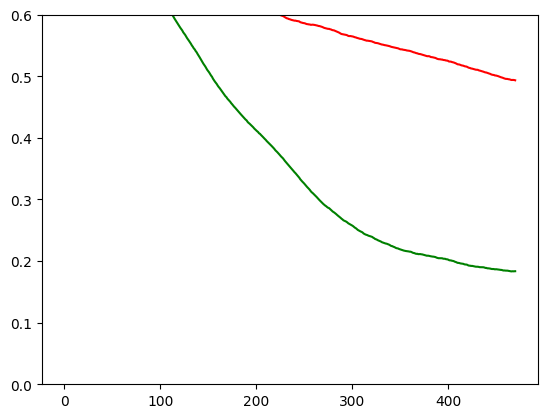

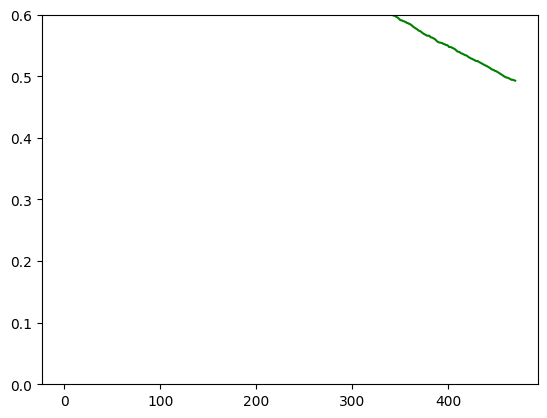

In [33]:
for i in range(7):
    a = ces_scratch.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='r')
    a = ces_pre.mean(axis=-1)[i]
    a = np.convolve(a, np.ones(30)/30, mode='valid')
    plt.plot(a, c='g')
    plt.ylim(0, 0.6)
    plt.show()